### Loading, Preprocessing of Data

In [1]:
# Loading cycles, hi_ga for all specimens, both L1 and L2
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils.load_data import load_data

path = 'data'
filename = os.path.join(path, 'specimens_hi_ga.xlsx')
Xtrain, Ytrain, Xtest, Ytest, [train_specimens, test_specimens] = load_data(filename, threshold=0.845)
print(f'L1 specimens to be used for model training: {train_specimens}')
print(f'L2 specimens to be tested: {test_specimens}')

L1 specimens to be used for model training: ['ca_1', 'ca_2', 'ca_3', 'ca_4', 'va_1', 'va_2', 'va_3', 'va_4', 'va_5', 'sp_1', 'sp_2', 'sp_3', 'sp_4', 'sp_5', 'sp_7']
L2 specimens to be tested: ['L2-03', 'L2-04', 'L2-05', 'L2-07']


In [2]:
# Dynamic weights
from utils.dynamic_weigths import weight_calculation
weights = weight_calculation(Xtrain, Xtest)

print(f'Initial sequences length of train dataset: {[len(hi) for hi in Xtrain.values()]}')
print(f'Initial sequences length of test dataset: {[len(hi) for hi in Xtest.values()]}')
print(f'Weight size for test dataset: {[weights[test].shape for test in test_specimens]}')

Initial sequences length of train dataset: [494, 261, 239, 469, 409, 311, 436, 687, 485, 1593, 503, 1614, 1130, 835, 1639]
Initial sequences length of test dataset: [780, 370, 751, 389]
Weight size for test dataset: [(15, 780), (15, 370), (15, 751), (15, 389)]


In [4]:
# Fit the scaler on all training specimens
def scale_data(data):
    scaler = MinMaxScaler()
    all_values = np.concatenate(list(data.values()))
    scaler.fit(all_values.reshape(-1,1))
    scaled_data = {specimen: scaler.transform(data[specimen].values.reshape(-1,1)) for specimen in data.keys()}
    return scaled_data, scaler

# Fit only on training data, the hi_ga sequences do not need scaling since they are already in the range [0,1]
# Xtrain_scaled, Xscaler = scale_data(Xtrain)
Ytrain_scaled, Yscaler = scale_data(Ytrain)
# Xtest_scaled = {specimen: Xscaler.transform(Xtest[specimen].values.reshape(-1,1)) for specimen in specimens[1]}
Ytest_scaled = {specimen: Yscaler.transform(Ytest[specimen].values.reshape(-1,1)) for specimen in test_specimens}

In [ ]:
# Scale each specimen separately (skip this step)

# scaler = MinMaxScaler()
# def scale(data, scaler):
#     return scaler.fit_transform(data)
# Ytrain_scaled = {specimen: scale(Ytrain[specimen].values.reshape(-1,1), scaler) for specimen in train_specimens}
# Ytest_scaled = {specimen: scale(Ytest[specimen].values.reshape(-1,1), scaler) for specimen in test_specimens}

In [5]:
# Save the scaler 
import pickle
with open('models\scaler.pkl', 'wb') as f:
    pickle.dump(Yscaler, f)

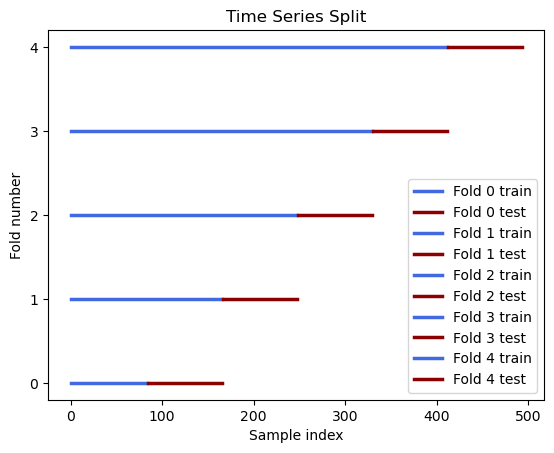

In [4]:
# Split Xtrain, Ytrain into training and validation sets for each specimen to perform time series cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
# Example of a single specimen
fig, ax = plt.subplots()
for i, (train, test) in enumerate(tscv.split(Xtrain['ca_1'])):
    ax.plot(train, [i]*len(train), label=f'Fold {i} train', color='royalblue', linewidth=2.5)
    ax.plot(test, [i]*len(test), label=f'Fold {i} test', color='darkred', linewidth=2.5)
ax.set_title('Time Series Split')
ax.set_yticks([0,1,2,3,4])
ax.set_ylabel('Fold number')
ax.set_xlabel('Sample index')
ax.legend()
plt.show()

### Keras Tuner

In [ ]:
# Implement the default Bayesian Optimization for hyperparameter tuning (skip this step)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization

# Define the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=8, max_value=128, step=4),
                   input_shape=(None, X.shape[2]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, bias_initializer = 'ones'))
    model.compile(loss='mse', optimizer='adam')
    return model

# Example of a single specimen
specimen = 'sp_1'
X = Xtrain[specimen].values.reshape(1,-1,1)
y = Ytrain_scaled[specimen].reshape(1,-1,1)

tuner = BayesianOptimization(
    build_model,
    objective='loss',
    max_trials=20,
    executions_per_trial=1,
    directory='models/tuning',
    project_name=specimen)

# Perform hyperparameter tuning
tuner.search(X, y, epochs=100, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Train the model with the best hyperparameters on the entire data set
best_model = build_model(best_hyperparameters)
best_model.fit(X, y, epochs=100, batch_size=1, shuffle=False, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])

predicted_rul = best_model.predict(X)

# Plot true vs predicted RUL
plt.plot(y.reshape(-1,), label='True')
plt.plot(predicted_rul.reshape(-1,), label='Predicted')
plt.legend()
plt.show()


In [ ]:
# Implement the time series cross validation Bayesian Optimization for hyperparameter tuning
from utils.tscv_opt import TSCVBayesianOptimization
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Define the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=8, max_value=128, step=4),
                input_shape=(None, X.shape[2]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, bias_initializer = 'ones'))
    model.compile(loss='mse', optimizer='adam')
    return model

def early_stopping(metric='val_loss'):
    return EarlyStopping(monitor=metric, patience=10, restore_best_weights=True)

# Perform hyperparameter tuning for each specimen
lstmn_models = {}
for specimen in train_specimens:
    # Reshape X to be (samples, time steps, features)
    X = Xtrain[specimen].values.reshape(1,-1,1)
    # Reshape y to be (samples, time steps, targets)
    y = Ytrain_scaled[specimen].reshape(1,-1,1)

    # Define the tuner
    tuner = TSCVBayesianOptimization(
        hypermodel=build_model,
        objective='val_loss',
        max_trials=30,
        executions_per_trial=1,
        directory='models/lstm_hyperparameter_tuning',
        project_name=specimen)

    # Perform hyperparameter tuning
    tuner.search(X, y, epochs=100, batch_size=1, shuffle=False, callbacks=[early_stopping()])

    # Get the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(best_hyperparameters.values)

    # Train the model with the best hyperparameters on the entire data set
    best_model = build_model(best_hyperparameters)
    best_model.fit(X, y, epochs=100, batch_size=1, shuffle=False, callbacks=[early_stopping('loss')])
    lstmn_models[specimen] = best_model
    
    # Predict the RUL
    predicted_rul = best_model.predict(X)
    # Plot true vs predicted RUL
    plt.plot(y.reshape(-1,), label='True')
    plt.plot(predicted_rul.reshape(-1,), label='Predicted')
    plt.legend()
    plt.show()

# Save the models
path = 'models/lstmn_models'
for specimen, model in lstmn_models.items():
    model.save(os.path.join(path, f'{specimen}_lstmn_model.keras'))

In [6]:
# Load the models in a dictionary with the specimen names as keys
from keras.models import load_model
path = 'models/lstmn_models'
lstmn_models = {specimen: load_model(os.path.join(path, f'{specimen}_lstmn_model.keras')) for specimen in train_specimens}

### Hyperopt (skipped)

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Example of a single specimen
specimen = 'sp_1'
X = Xtrain[specimen].values.reshape(1,-1,1)
y = Ytrain_scaled[specimen].reshape(1,-1,1)

# Define the model
def build_model(params):
    lstm_units = int(params['lstm_units'])
    dropout_rate = params['dropout_rate']
    
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(None, X.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, bias_initializer='ones'))

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

# Define cross-validation splits
tscv = TimeSeriesSplit(n_splits=5)

def objective(hyperparameters):
    model = build_model(hyperparameters)

    validation_losses = []
    # Perform cross-validation
    for train_index, val_index in tscv.split(X.squeeze()):
        x_train_fold, x_val_fold = X[:,train_index], X[:,val_index]
        y_train_fold, y_val_fold = y[:,train_index], y[:,val_index]

        model.fit(x_train_fold, y_train_fold, batch_size=1, epochs=100, verbose=0, shuffle=False, validation_data=(x_val_fold, y_val_fold), callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)])
        validation_loss = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        validation_losses.append(validation_loss)
    
    # Compute mean validation loss
    mean_validation_loss = np.mean(validation_losses)
    
    return {'loss': mean_validation_loss, 'status': STATUS_OK}

# Define search space
param_space = {'lstm_units': hp.quniform('lstm_units', 8, 128, 4),
               'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5)}

algo = tpe.suggest
max_evals = 20

# Define trials object to keep track of the optimization process
trials = Trials()

# Run the optimization
best = fmin(objective, space=param_space, algo=algo, max_evals=max_evals, trials=trials)

# Get the optimal hyperparameters
optimal_units = int(best['lstm_units'])
optimal_dropout_rate = best['dropout_rate']

model = build_model(best)

# Train your final model with all available data
model.fit(X, y, batch_size=1, epochs=100, verbose=0, shuffle=False, callbacks=[EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)])

predicted_rul = model.predict(X)
# Plot true vs predicted RUL
plt.plot(y.reshape(-1,), label='True')
plt.plot(predicted_rul.reshape(-1,), label='Predicted')
plt.legend()
plt.show()

### Training with specific hyperparams (for simplicity)

In [ ]:
# Following the papers implementation, LSTM models are trained for each specimen separately,
# with a prespecified number of lstm_units and dropout_rate, derived from the hyperparameter tuning process
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

lstmn_models = {}
for specimen in train_specimens:
    # Reshape X to be 3D (samples, time steps, features)
    X = Xtrain[specimen].values.reshape(1,-1,1)
    # Reshape y to be 3D (samples, time steps, targets)
    y = Ytrain_scaled[specimen].reshape(1,-1,1)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(None, X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(1, bias_initializer = 'ones'))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X, y, epochs=100, batch_size=1, verbose=0, shuffle=False, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])
    lstmn_models[specimen] = model

    predicted_rul = model.predict(X)
    # plot true vs predicted RUL
    plt.plot(y.reshape(-1,), label='True')
    plt.plot(predicted_rul.reshape(-1,), label='Predicted')
    plt.legend()
    plt.show()

### Results for a single specimen

1/1 [==============================] - 0s 290ms/step


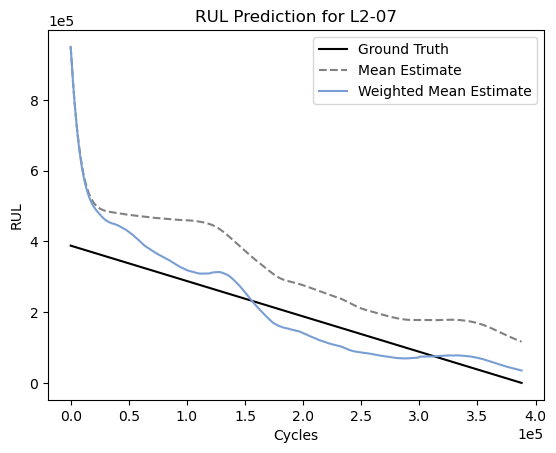

In [7]:
# Select a single test specimen
specimen = 'L2-07'
Xt = Xtest[specimen].values.reshape(1,-1,1)
yt = Ytest[specimen]
cycles = yt[::-1]

# Ensemble prediction
predicted_rul = [lstmn_models[specimen].predict(Xt).reshape(-1,) for specimen in train_specimens]
## Weighted average 
weighted_rul = [weights[specimen][i] * predicted_rul[i] for i, _ in enumerate(train_specimens)]

# Plot true vs predicted RUL for both weighted and unweighted predictions
y_pred_vanilla = np.mean(predicted_rul, axis=0)
y_pred_vanilla = Yscaler.inverse_transform(y_pred_vanilla.reshape(-1,1)).reshape(-1,)
y_pred = np.mean(weighted_rul, axis=0)
y_pred = Yscaler.inverse_transform(y_pred.reshape(-1,1)).reshape(-1,)
yt = Ytest[specimen].values

fig, ax = plt.subplots()
ax.plot(cycles, yt, label='Ground Truth', color='black')
ax.plot(cycles, y_pred_vanilla, '--', label='Mean Estimate', color='#808183')
ax.plot(cycles, y_pred, label='Weighted Mean Estimate', color='#799ed3')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
ax.set_title(f'RUL Prediction for {specimen}')
ax.set_xlabel('Cycles')
ax.set_ylabel('RUL')
ax.legend()
plt.show()

1/1 [==============================] - 0s 18ms/step


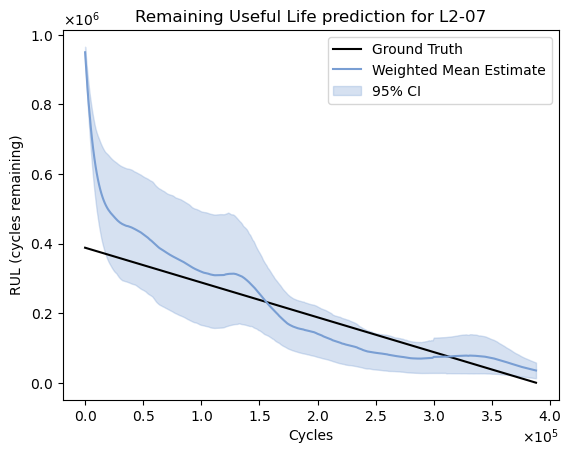

In [7]:
from utils.figures import plot_predictions
import pickle

with open('models/scaler.pkl', 'rb') as f:
    Yscaler = pickle.load(f)

specimen = 'L2-07'
Xt = Xtest[specimen].values.reshape(1,-1,1)
yt = Ytest[specimen]

# Ensemble prediction
predicted_rul = [lstmn_models[specimen].predict(Xt).reshape(-1,) for specimen in train_specimens]
## Weighted average 
weighted_rul = [weights[specimen][i] * predicted_rul[i] for i, _ in enumerate(train_specimens)]

fig, lower, upper = plot_predictions(yt, weighted_rul, specimen, scaler=Yscaler)